In [1]:
%matplotlib inline

import os 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rethinking.stan import StanCache

In [2]:
DATA_FOLDER = '../data'
MILK_FULLPATH = os.path.join(DATA_FOLDER, 'milk.csv')

In [3]:
milk = pd.read_csv(MILK_FULLPATH)
milk.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [4]:
milk.describe()

,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
count,29.000000,29.000000,29.000000,29.000000,29.000000,17.000000
mean,0.641724,33.990345,16.403448,49.606207,14.726897,67.575882
std,0.161402,14.286670,4.846878,14.055174,24.770469,5.968612
min,0.460000,3.930000,7.370000,27.090000,0.120000,55.160000
25%,0.490000,21.220000,13.000000,37.800000,1.620000,64.540000
50%,0.600000,36.840000,15.800000,48.640000,3.470000,68.850000
75%,0.730000,46.080000,20.770000,60.120000,10.720000,71.260000
max,0.970000,55.510000,25.300000,71.910000,97.720000,76.300000


In [5]:
sm1 = StanCache(filename='../models/cortex.stan', cache_path='../cache').compile()
sm1.model_code

data {
    int<lower=0> N;
    vector[N] X;
    vector[N] kcal_per_g;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;

}
transformed parameters {
    vector[N] mu;

    mu = alpha + beta * X;
}
model {
    alpha ~ normal(0, 100);
    beta ~ normal(0, 1);
    //sigma ~ uniform(0, 1);
    kcal_per_g ~ normal(mu, sigma);
}



In [6]:
cortex_data = dict(
    N=milk.shape[0],
    X=milk.loc[:, 'neocortex.perc'],
    kcal_per_g=milk.loc[:, 'kcal.per.g']
)

try:
    fit1_1 = sm1.sampling(data=cortex_data)
except RuntimeError as e:
    print(e)

/home/gianluca/.virtualenvs/rethinking/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Initialization failed.


This failure is due to the missing values in the `neocortex.perc` feature.

In [7]:
mask = np.sum(milk.isna(), axis=1) >= 1
milk_cc = milk[~mask]
milk_cc.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
5,New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54
6,New World Monkey,A palliata,0.56,29.66,23.46,46.88,5.37,64.54
7,New World Monkey,Cebus apella,0.89,53.41,15.80,30.79,2.51,67.64
9,New World Monkey,S sciureus,0.92,50.58,22.33,27.09,0.68,68.85


In [8]:
cortex_data = dict(
    N=milk_cc.shape[0],
    X=milk_cc.loc[:, 'neocortex.perc'],
    kcal_per_g=milk_cc.loc[:, 'kcal.per.g']
)

fit1_2 = sm1.sampling(data=cortex_data)
fit1_2

/home/gianluca/.virtualenvs/rethinking/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/gianluca/git/rethinking/src/rethinking/stan.py:95: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(results, f)


Inference for Stan model: anon_model_e4c6cb5fb6b24068da802bd5e1052a84.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha    0.33    0.02   0.57  -0.79  -0.04   0.34   0.71   1.45    923    1.0
beta   4.8e-3  2.8e-4 8.4e-3  -0.01-6.5e-4 4.8e-3   0.01   0.02    923    1.0
sigma    0.19  1.2e-3   0.04   0.13   0.16   0.19   0.21   0.29   1136    1.0
mu[0]     0.6  3.6e-3   0.11   0.37   0.52    0.6   0.67   0.82   1008    1.0
mu[1]    0.64  1.2e-3   0.05   0.54   0.61   0.64   0.68   0.75   1931    1.0
mu[2]    0.64  1.2e-3   0.05   0.54   0.61   0.64   0.68   0.75   1931    1.0
mu[3]    0.66  7.5e-4   0.05   0.56   0.63   0.66   0.69   0.75   4000    1.0
mu[4]    0.66  7.7e-4   0.05   0.57   0.63   0.66    0.7   0.76   4000    1.0
mu[5]    0.62  2.6e-3   0.09   0.44   0.56   0.62   0.67   0.79   1097    1.0
mu[6]    0.63  1.9e-3   0.07   

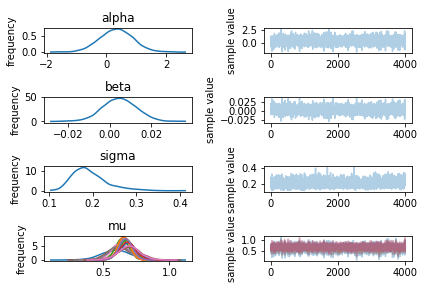

In [9]:
fit1_2.plot()
plt.tight_layout()
plt.show()

Let's now consider the logarithm of adult female body mass as an alternative predictor. Taking the logarithm of a predictor because:

> it is often true that scaling measurements like body mass are related by magnitudes to other variables. Taking the log of a measure translates the measure into magnitudes. So by using the logarithm of body mass hare, we're saying that we suspect that the magnitude of a mother's body mass is related to milk energy, in a linear fashion.

In [10]:
milk_cc['mass_log'] = np.log(milk_cc.loc[:, 'mass'])

/home/gianluca/.virtualenvs/rethinking/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [11]:
mass_data = dict(
    N=milk_cc.shape[0],
    X=milk_cc.loc[:, 'mass_log'],
    kcal_per_g=milk_cc.loc[:, 'kcal.per.g']
)

fit1_3 = sm1.sampling(data=mass_data)
fit1_3

/home/gianluca/.virtualenvs/rethinking/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/gianluca/git/rethinking/src/rethinking/stan.py:95: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(results, f)


Inference for Stan model: anon_model_e4c6cb5fb6b24068da802bd5e1052a84.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.7  1.4e-3   0.06   0.59   0.67    0.7   0.74   0.82   1725    1.0
beta    -0.03  5.9e-4   0.02  -0.08  -0.05  -0.03  -0.02   0.02   1721    1.0
sigma    0.18  9.0e-4   0.04   0.13   0.16   0.18    0.2   0.28   1949    1.0
mu[0]    0.68  1.1e-3   0.05   0.58   0.65   0.68   0.72   0.78   2028    1.0
mu[1]    0.65  8.1e-4   0.05   0.56   0.62   0.65   0.68   0.74   3214    1.0
mu[2]    0.65  8.1e-4   0.05   0.56   0.62   0.65   0.68   0.74   3252    1.0
mu[3]    0.68  1.0e-3   0.05   0.58   0.65   0.68   0.71   0.77   2228    1.0
mu[4]    0.72  1.6e-3   0.07   0.59   0.68   0.72   0.76   0.85   1642    1.0
mu[5]    0.77  2.6e-3    0.1   0.58   0.71   0.77   0.84   0.97   1546    1.0
mu[6]    0.73  1.8e-3   0.07   

In [12]:
sm2 = StanCache(filename='../models/multi.stan', cache_path='../cache').compile()
sm2.model_code

data {
    int<lower=0> N;
    int<lower=0> K;
    matrix[N, K] X;
    vector[N] kcal_per_g;
}
parameters {
    real alpha;
    vector[K] beta;
    real<lower=0> sigma;

}
transformed parameters {
    vector[N] mu;

    mu = alpha + X * beta;
}
model {
    alpha ~ normal(0, 100);
    beta ~ normal(0, 1);
    //sigma ~ uniform(0, 1);
    kcal_per_g ~ normal(mu, sigma);
}



In [13]:
multi_data = dict(
    N=milk_cc.shape[0],
    K=2,
    X=milk_cc.loc[:, ['neocortex.perc', 'mass_log']],
    kcal_per_g=milk_cc.loc[:, 'kcal.per.g']
)

fit2_1 = sm2.sampling(data=multi_data)
fit2_1

/home/gianluca/.virtualenvs/rethinking/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/gianluca/git/rethinking/src/rethinking/stan.py:95: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(results, f)


Inference for Stan model: anon_model_56df349a195d764972a68022d8c0d29d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha    -1.07    0.02   0.58  -2.24  -1.46  -1.06   -0.7   0.11    969    1.0
beta[0]   0.03  2.9e-4 9.0e-3 9.4e-3   0.02   0.03   0.03   0.05    951    1.0
beta[1]   -0.1  7.9e-4   0.03  -0.15  -0.11   -0.1  -0.08  -0.04   1196    1.0
sigma     0.14  1.3e-3   0.03   0.09   0.12   0.13   0.15   0.21    566   1.01
mu[0]     0.39  3.1e-3    0.1   0.19   0.32   0.39   0.46    0.6   1120    1.0
mu[1]     0.56  1.1e-3   0.05   0.46   0.53   0.56   0.59   0.65   1673    1.0
mu[2]     0.56  1.1e-3   0.05   0.46   0.53   0.56   0.58   0.65   1654    1.0
mu[3]     0.71  7.3e-4   0.04   0.64   0.69   0.71   0.74   0.79   2652    1.0
mu[4]     0.87  1.9e-3   0.07   0.73   0.83   0.87   0.92   1.01   1284    1.0
mu[5]     0.76  1.4e-

> By incorporating both predictor variables in the regression, the estimated association of both with the outcome has increased. The posterior mean for the association of neocortex percent has increased more than sixfold, and its 89% interval is not entirely above zero. The posterior mean for log body mass is more strongly negative.

# Multicollinearity

Let's see how multicollinearity can affect the posterior distributions of the predictor's coefficients.

In [14]:
milk.loc[:, ['perc.fat', 'perc.lactose']].corr()

,perc.fat,perc.lactose
perc.fat,1.000000,-0.941637
perc.lactose,-0.941637,1.000000


`perc.fat` and `perc.lactose` are strongly positively correlated. This causes multicollinearity.

Let's reuse the already compiled model `sm1`.

In [15]:
print(sm1.model_code)

data {
    int<lower=0> N;
    vector[N] X;
    vector[N] kcal_per_g;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;

}
transformed parameters {
    vector[N] mu;

    mu = alpha + beta * X;
}
model {
    alpha ~ normal(0, 100);
    beta ~ normal(0, 1);
    //sigma ~ uniform(0, 1);
    kcal_per_g ~ normal(mu, sigma);
}

None


In [16]:
fat_data = dict(
    N=milk.shape[0],
    X=milk['perc.fat'],
    kcal_per_g = milk['kcal.per.g']
)

sm1.sampling(data=fat_data)

/home/gianluca/.virtualenvs/rethinking/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/gianluca/git/rethinking/src/rethinking/stan.py:95: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(results, f)


Inference for Stan model: anon_model_e4c6cb5fb6b24068da802bd5e1052a84.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.3  1.1e-3   0.04   0.22   0.27    0.3   0.33   0.38   1463    1.0
beta     0.01  2.7e-5 1.1e-3 7.9e-3 9.3e-310.0e-3   0.01   0.01   1598    1.0
sigma    0.08  2.7e-4   0.01   0.06   0.07   0.08   0.09   0.11   1823    1.0
mu[0]    0.47  6.3e-4   0.02   0.42   0.45   0.47   0.48   0.51   1550    1.0
mu[1]    0.49  5.6e-4   0.02   0.45   0.48   0.49   0.51   0.54   1607    1.0
mu[2]    0.44  6.9e-4   0.03   0.39   0.43   0.44   0.46   0.49   1517    1.0
mu[3]    0.45  6.7e-4   0.03    0.4   0.43   0.45   0.47    0.5   1526    1.0
mu[4]    0.57  3.7e-4   0.02   0.54   0.56   0.57   0.59   0.61   2082    1.0
mu[5]    0.51  5.1e-4   0.02   0.47    0.5   0.51   0.53   0.55   1668    1.0
mu[6]     0.6  3.2e-4   0.02   

In [17]:
lactose_data = dict(
    N=milk.shape[0],
    X=milk['perc.lactose'],
    kcal_per_g = milk['kcal.per.g']
)

sm1.sampling(data=lactose_data)

/home/gianluca/.virtualenvs/rethinking/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/gianluca/git/rethinking/src/rethinking/stan.py:95: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(results, f)


Inference for Stan model: anon_model_e4c6cb5fb6b24068da802bd5e1052a84.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha    1.16  1.4e-3   0.05   1.06   1.13   1.16   1.19   1.26   1182    1.0
beta    -0.01  2.7e-5 9.5e-4  -0.01  -0.01  -0.01-9.9e-3-8.6e-3   1209    nan
sigma    0.07  3.1e-4   0.01   0.05   0.06   0.07   0.07   0.09   1065    1.0
mu[0]    0.45  5.1e-4   0.02    0.4   0.43   0.45   0.46   0.49   1871    1.0
mu[1]    0.49  4.1e-4   0.02   0.45   0.48   0.49    0.5   0.53   2139    1.0
mu[2]    0.44  5.4e-4   0.02   0.39   0.42   0.44   0.45   0.48   1822    1.0
mu[3]    0.41  6.2e-4   0.03   0.36   0.39   0.41   0.42   0.46   1681    1.0
mu[4]     0.6  2.1e-4   0.01   0.58    0.6    0.6   0.61   0.63   4000    1.0
mu[5]    0.58  2.2e-4   0.01   0.55   0.57   0.58   0.59   0.61   4000    1.0
mu[6]    0.67  2.3e-4   0.01   

In [18]:
print(sm2.model_code)

data {
    int<lower=0> N;
    int<lower=0> K;
    matrix[N, K] X;
    vector[N] kcal_per_g;
}
parameters {
    real alpha;
    vector[K] beta;
    real<lower=0> sigma;

}
transformed parameters {
    vector[N] mu;

    mu = alpha + X * beta;
}
model {
    alpha ~ normal(0, 100);
    beta ~ normal(0, 1);
    //sigma ~ uniform(0, 1);
    kcal_per_g ~ normal(mu, sigma);
}

None


In [19]:
multicollinearity_data = dict(
    N=milk.shape[0],
    K=2,
    X=milk.loc[:, ['perc.fat', 'perc.lactose']],
    kcal_per_g=milk.loc[:, 'kcal.per.g']
)

sm2.sampling(data=multicollinearity_data)

/home/gianluca/.virtualenvs/rethinking/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/gianluca/git/rethinking/src/rethinking/stan.py:95: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(results, f)


Inference for Stan model: anon_model_56df349a195d764972a68022d8c0d29d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     1.01  7.1e-3   0.22   0.58   0.87   1.01   1.16   1.45    979    1.0
beta[0] 1.9e-3  8.4e-5 2.7e-3-3.4e-3 1.8e-4 2.0e-3 3.6e-3 7.3e-3   1013    1.0
beta[1]-8.8e-3  9.1e-5 2.7e-3  -0.01  -0.01-8.7e-3-7.0e-3-3.4e-3    890    1.0
sigma     0.07  3.1e-4   0.01   0.05   0.06   0.07   0.07   0.09   1057   1.01
mu[0]     0.45  3.6e-4   0.02    0.4   0.43   0.45   0.46   0.49   3546    1.0
mu[1]     0.49  3.0e-4   0.02   0.45   0.48   0.49    0.5   0.53   3818    1.0
mu[2]     0.43  3.6e-4   0.02   0.39   0.42   0.43   0.45   0.48   3705    1.0
mu[3]     0.41  4.7e-4   0.02   0.36   0.39   0.41   0.43   0.46   2737    1.0
mu[4]      0.6  3.3e-4   0.02   0.57   0.59    0.6   0.61   0.63   2391    1.0
mu[5]     0.57  6.5e-

# Many categories

In [20]:
milk.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [21]:
clade_dummies = pd.get_dummies(milk.clade, drop_first=True)
clade_dummies.head()

,New World Monkey,Old World Monkey,Strepsirrhine
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


In [22]:
sm2_1 = StanCache(filename='../models/categories.stan', cache_path='../cache').compile()
sm2_1.model_code

data {
    int N;
    int K;
    matrix[N, K] X;
    vector[N] k;
}
parameters {
    real alpha;
    vector[K] beta;
    real<lower=0> sigma;
}
transformed parameters {
    vector[N] mu;
    mu = alpha + X * beta;
}
model {
    sigma ~ uniform(0, 10);
    beta ~ normal(0, 1);
    alpha ~ normal(0.6, 10);
    k ~ normal(mu, sigma);
}



In [23]:
categories_data = dict(
    N=milk.shape[0],
    K=clade_dummies.shape[1],
    X=clade_dummies.as_matrix(),
    k=milk['kcal.per.g']
)

fit2_1 = sm2_1.sampling(data=categories_data)
fit2_1

/home/gianluca/.virtualenvs/rethinking/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_f1de51cd64fcbfcaffdac5aed23535d4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.55  1.1e-3   0.04   0.46   0.52   0.55   0.57   0.63   1570    1.0
beta[0]   0.17  1.4e-3   0.06   0.05   0.13   0.17   0.21   0.29   1890    1.0
beta[1]   0.24  1.6e-3   0.07    0.1    0.2   0.24   0.29   0.38   1991    1.0
beta[2]  -0.04  1.6e-3   0.07  -0.18  -0.09  -0.04   0.01   0.11   2117    1.0
sigma     0.13  4.3e-4   0.02    0.1   0.12   0.13   0.14   0.18   2180    1.0
mu[0]     0.51  9.3e-4   0.06   0.39   0.47   0.51   0.55   0.63   4000    1.0
mu[1]     0.51  9.3e-4   0.06   0.39   0.47   0.51   0.55   0.63   4000    1.0
mu[2]     0.51  9.3e-4   0.06   0.39   0.47   0.51   0.55   0.63   4000    1.0
mu[3]     0.51  9.3e-4   0.06   0.39   0.47   0.51   0.55   0.63   4000    1.0
mu[4]     0.51  9.3e-

Alternatively, one can use a vector of intercepts paramaters, where each category has its own intercept. The results will be equivalent, but the results are now more easily interpretable.

In [24]:
sm2_1 = StanCache(filename='../models/categories_intercept.stan', cache_path='../cache').compile()
sm2_1.model_code

data {
    int N;
    int J;
    int<lower=1, upper=J> clade_id[N];
    vector[N] k;
}
parameters {
    real alpha[J];
    real<lower=0> sigma;
}
transformed parameters {
    real mu[N];

    for (n in 1:N) {
        mu[n] = alpha[clade_id[n]];
    }
}
model {
    sigma ~ uniform(0, 10);
    alpha ~ normal(0.6, 10);
    k ~ normal(mu, sigma);
}



In [25]:
milk['clade_id'] = pd.Categorical(milk.clade).codes + 1

In [26]:
categories_data2 = dict(
    N=milk.shape[0],
    J=4,
    clade_id=milk['clade_id'],
    k=milk['kcal.per.g']
)

fit2_2 = sm2_1.sampling(data=categories_data2)
fit2_2

/home/gianluca/.virtualenvs/rethinking/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_0a009dcd7022e0ac539f9078a301b0d5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[0]   0.55  6.9e-4   0.04   0.46   0.52   0.55   0.58   0.63   4000    1.0
alpha[1]   0.71  7.0e-4   0.04   0.63   0.68   0.71   0.74    0.8   4000    1.0
alpha[2]   0.79  8.6e-4   0.05   0.68   0.75   0.79   0.82    0.9   4000    1.0
alpha[3]   0.51  9.2e-4   0.06   0.39   0.47   0.51   0.54   0.62   4000    1.0
sigma      0.13  3.2e-4   0.02    0.1   0.12   0.13   0.14   0.18   4000    1.0
mu[0]      0.51  9.2e-4   0.06   0.39   0.47   0.51   0.54   0.62   4000    1.0
mu[1]      0.51  9.2e-4   0.06   0.39   0.47   0.51   0.54   0.62   4000    1.0
mu[2]      0.51  9.2e-4   0.06   0.39   0.47   0.51   0.54   0.62   4000    1.0
mu[3]      0.51  9.2e-4   0.06   0.39   0.47   0.51   0.54   0.62   4000    1.0
mu[4]      